In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time

In [3]:
INPUT_SEQUENCE_LENGTH = 168
OUTPUT_SEQUENCE_LENGTH = 72 

In [4]:
class ClassicalLSTMModel(nn.Module):
    """
    Builds a purely classical LSTM model for multi-step time-series forecasting.
    Predicts the next 3 days (72 hours) of air quality classes.
    """
    def __init__(self, n_features, n_lstm_units=4, output_len=OUTPUT_SEQUENCE_LENGTH):
        super(ClassicalLSTMModel, self).__init__()
        
        # 1. Standard LSTM Layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_lstm_units,
            num_layers=1,
            batch_first=True,
            dropout=0.2
        )
        
        # 2. Feed-Forward Classifier for multi-step prediction
        self.classifier = nn.Linear(n_lstm_units, output_len)
        
    def forward(self, x):        
        # 1. Pass data through the classical LSTM
        lstm_out, _ = self.lstm(x)
        
        # 2. Extract features from the last timestep
        final_lstm_output = lstm_out[:, -1, :]
        
        # 3. Pass through classifier to get predictions for all timesteps
        output = self.classifier(final_lstm_output)
        
        # 4. Apply sigmoid activation to get probabilities for each timestep
        return torch.sigmoid(output)

In [5]:
def load_and_prepare_data():
    """Load and prepare data with memory optimizations"""
    print("Loading data...")
    if not os.path.exists('air_quality_2024_preproccessed.parquet'):
        raise FileNotFoundError("The data file 'air_quality_2024_preproccessed.parquet' was not found.")
    df = pq.read_table('air_quality_2024_preproccessed.parquet').to_pandas()
    print(f"Dataset shape: {df.shape}")
    
    le_location = LabelEncoder()
    df['location_encoded'] = le_location.fit_transform(df['location'])
    df = df.sort_values(['location_encoded', 'month', 'day', 'hour'])
    
    feature_columns = [col for col in df.columns if col not in [
        'class', 'location', 'month', 'day', 'hour', 'location_encoded'
    ]]
    feature_columns.append('location_encoded')
    
    print(f"Feature columns: {feature_columns}")
    print(f"Number of features: {len(feature_columns)}")
    
    return df, feature_columns, le_location

In [6]:
def create_sequences_memory_efficient(df, feature_columns, 
                                    input_len=INPUT_SEQUENCE_LENGTH,
                                    output_len=OUTPUT_SEQUENCE_LENGTH,
                                    stride=24):
    """
    Create sequences for multi-step forecasting.
    Input: `input_len` hours of data
    Output: `output_len` hours of predictions
    """
    print(f"Creating sequences with input length={input_len}, output length={output_len}...")
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[feature_columns])
    X_scaled = pd.DataFrame(X_scaled, columns=feature_columns, index=df.index)
    
    X_sequences, y_sequences, location_indices = [], [], []
    unique_locations = df['location_encoded'].unique()
    
    for i, loc in enumerate(unique_locations):
        loc_df = df[df['location_encoded'] == loc]
        loc_X = X_scaled.loc[loc_df.index]
        loc_y = loc_df['class'].values
        
        # Calculate valid range to ensure we have enough data for output sequence
        max_start_idx = len(loc_df) - input_len - output_len
        
        for j in range(0, max_start_idx, stride):
            X_seq = loc_X.iloc[j : j + input_len].values
            # Get the next `output_len` hours of class data
            y_target = loc_y[j + input_len : j + input_len + output_len]
            
            X_sequences.append(X_seq)
            y_sequences.append(y_target)
            location_indices.append(loc)
        
        if (i+1) % 100 == 0:
            print(f"Processed location {i+1}/{len(unique_locations)}")
    
    X_sequences = np.array(X_sequences, dtype=np.float32)
    y_sequences = np.array(y_sequences, dtype=np.float32)
    location_indices = np.array(location_indices)
    
    print(f"Total sequences: {X_sequences.shape[0]}")
    print(f"Input sequence shape: {X_sequences.shape}")
    print(f"Output sequence shape: {y_sequences.shape}")
    
    return X_sequences, y_sequences, location_indices, scaler

In [7]:
def train_model_pytorch(model, train_loader, val_loader, epochs=10, patience=3):
    """Trains the PyTorch model for multi-step forecasting."""
    print("Starting training with PyTorch...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    history = defaultdict(list)
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        train_loss, train_correct, train_samples = 0, 0, 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
            preds = (outputs > 0.5).float()
            train_correct += (preds == y_batch).sum().item()
            train_samples += y_batch.size(0) * y_batch.size(1)  
        
        train_loss /= train_samples
        train_acc = train_correct / train_samples
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        
        # Validation
        model.eval()
        val_loss, val_correct, val_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                val_loss += loss.item() * X_batch.size(0)
                preds = (outputs > 0.5).float()
                val_correct += (preds == y_batch).sum().item()
                val_samples += y_batch.size(0) * y_batch.size(1)
        
        val_loss /= val_samples
        val_acc = val_correct / val_samples
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        
        scheduler.step(val_loss)
        
        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {train_loss:.4f}, Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} - "
              f"Duration: {epoch_duration:.2f}s")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_classical_lstm_model.pth')
            patience_counter = 0
            print("  -> Validation loss improved. Saving model.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("  -> Early stopping triggered.")
                break
                
    model.load_state_dict(torch.load('best_classical_lstm_model.pth'))
    return model, history

In [8]:
def plot_training_history(history):
    """Plot training history for multi-step forecasting"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    ylabel = 'Accuracy (per timestep)'
    plt.ylabel(ylabel)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('classical_training_history_multistep.png', dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
def plot_example_predictions(model, X_test, y_test, num_examples=3):
    """Plot example predictions vs actual values"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    with torch.no_grad():
        # Get predictions for first few test samples
        sample_indices = np.random.choice(len(X_test), num_examples, replace=False)
        
        plt.figure(figsize=(15, 5 * num_examples))
        
        for i, idx in enumerate(sample_indices):
            X_sample = torch.tensor(X_test[idx:idx+1]).to(device)
            y_true = y_test[idx]
            
            # Get prediction
            y_pred = model(X_sample).cpu().numpy()[0]
            
            # Plot
            plt.subplot(num_examples, 1, i+1)
            hours = np.arange(1, OUTPUT_SEQUENCE_LENGTH + 1)
            plt.plot(hours, y_true, 'bo-', label='Actual')
            plt.plot(hours, y_pred, 'ro--', label='Predicted')
            plt.title(f'Example {i+1}: Air Quality Prediction (Next 72 Hours)')
            plt.xlabel('Hours Ahead')
            plt.ylabel('Air Quality Class')
            plt.yticks([0, 1], ['Good', 'Poor'])
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('example_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()

In [10]:
if torch.cuda.is_available():
    print(f"✅ Found GPU: {torch.cuda.get_device_name(0)}. Using CUDA.")
else:
    print("❌ No GPU found. The script will run on the CPU.")

✅ Found GPU: NVIDIA GeForce RTX 3050 Laptop GPU. Using CUDA.


In [11]:
df, feature_columns, le_location = load_and_prepare_data()

print("Using a subset of data for demonstration (first 400 locations)...")
unique_locs_subset = df['location_encoded'].unique()[:400]
df_subset = df[df['location_encoded'].isin(unique_locs_subset)]

# Create sequences with configurable lengths
X_sequences, y_sequences, location_indices, scaler = create_sequences_memory_efficient(
    df_subset, 
    feature_columns, 
    input_len=INPUT_SEQUENCE_LENGTH,
    output_len=OUTPUT_SEQUENCE_LENGTH,
    stride=24
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=location_indices
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test target shape: {y_test.shape}")


Loading data...
Dataset shape: (3513600, 9)
Feature columns: ['PM25_ug_m3', 'PM25_MERRA2', 'DUSMASS25', 'DUSMASS', 'location_encoded']
Number of features: 5
Using a subset of data for demonstration (first 400 locations)...
Creating sequences with input length=168, output length=72...
Processed location 100/400
Processed location 200/400
Processed location 300/400
Processed location 400/400
Total sequences: 142400
Input sequence shape: (142400, 168, 5)
Output sequence shape: (142400, 72)
Training set shape: (113920, 168, 5)
Test set shape: (28480, 168, 5)
Training target shape: (113920, 72)
Test target shape: (28480, 72)


In [12]:
batch_size = 16

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

del X_sequences, y_sequences, location_indices, X_train, X_test, y_train, y_test
gc.collect()

0

In [13]:
n_lstm_units = 8

model = ClassicalLSTMModel(
    n_features=len(feature_columns), 
    n_lstm_units=n_lstm_units,  
    output_len=OUTPUT_SEQUENCE_LENGTH
)
print("\nClassical LSTM Model Architecture:")
print(model)


Classical LSTM Model Architecture:
ClassicalLSTMModel(
  (lstm): LSTM(5, 8, batch_first=True, dropout=0.2)
  (classifier): Linear(in_features=8, out_features=72, bias=True)
)


/home/abdelrahmanelsayed/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Starting training with PyTorch...
Epoch 1/50 - Loss: 0.0075, Acc: 0.7243 - Val Loss: 0.0073, Val Acc: 0.7347 - Duration: 9.13s
  -> Validation loss improved. Saving model.
Epoch 2/50 - Loss: 0.0072, Acc: 0.7402 - Val Loss: 0.0071, Val Acc: 0.7449 - Duration: 9.98s
  -> Validation loss improved. Saving model.
Epoch 3/50 - Loss: 0.0071, Acc: 0.7431 - Val Loss: 0.0070, Val Acc: 0.7478 - Duration: 8.21s
  -> Validation loss improved. Saving model.
Epoch 4/50 - Loss: 0.0070, Acc: 0.7469 - Val Loss: 0.0070, Val Acc: 0.7471 - Duration: 8.30s
  -> Validation loss improved. Saving model.
Epoch 5/50 - Loss: 0.0070, Acc: 0.7469 - Val Loss: 0.0069, Val Acc: 0.7522 - Duration: 9.58s
  -> Validation loss improved. Saving model.
Epoch 6/50 - Loss: 0.0070, Acc: 0.7482 - Val Loss: 0.0069, Val Acc: 0.7522 - Duration: 8.85s
  -> Validation loss improved. Saving model.
Epoch 7/50 - Loss: 0.0069, Acc: 0.7514 - Val Loss: 0.0069, Val Acc: 0.7526 - Duration: 8.79s
  -> Validation loss improved. Saving model.


/tmp/ipykernel_4992/2924380635.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_classical_lstm_model.pth'))


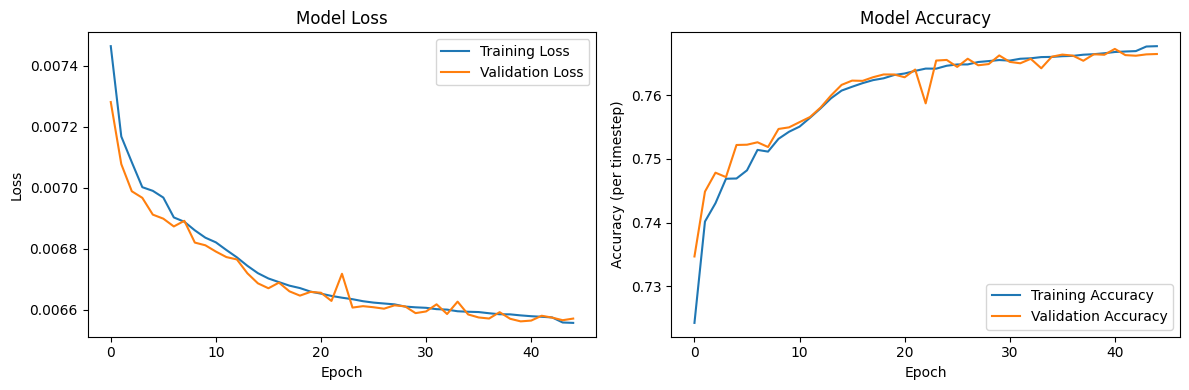

In [14]:
model, history = train_model_pytorch(model, train_loader, val_loader, epochs=50, patience=5)

plot_training_history(history)


Generating example predictions...


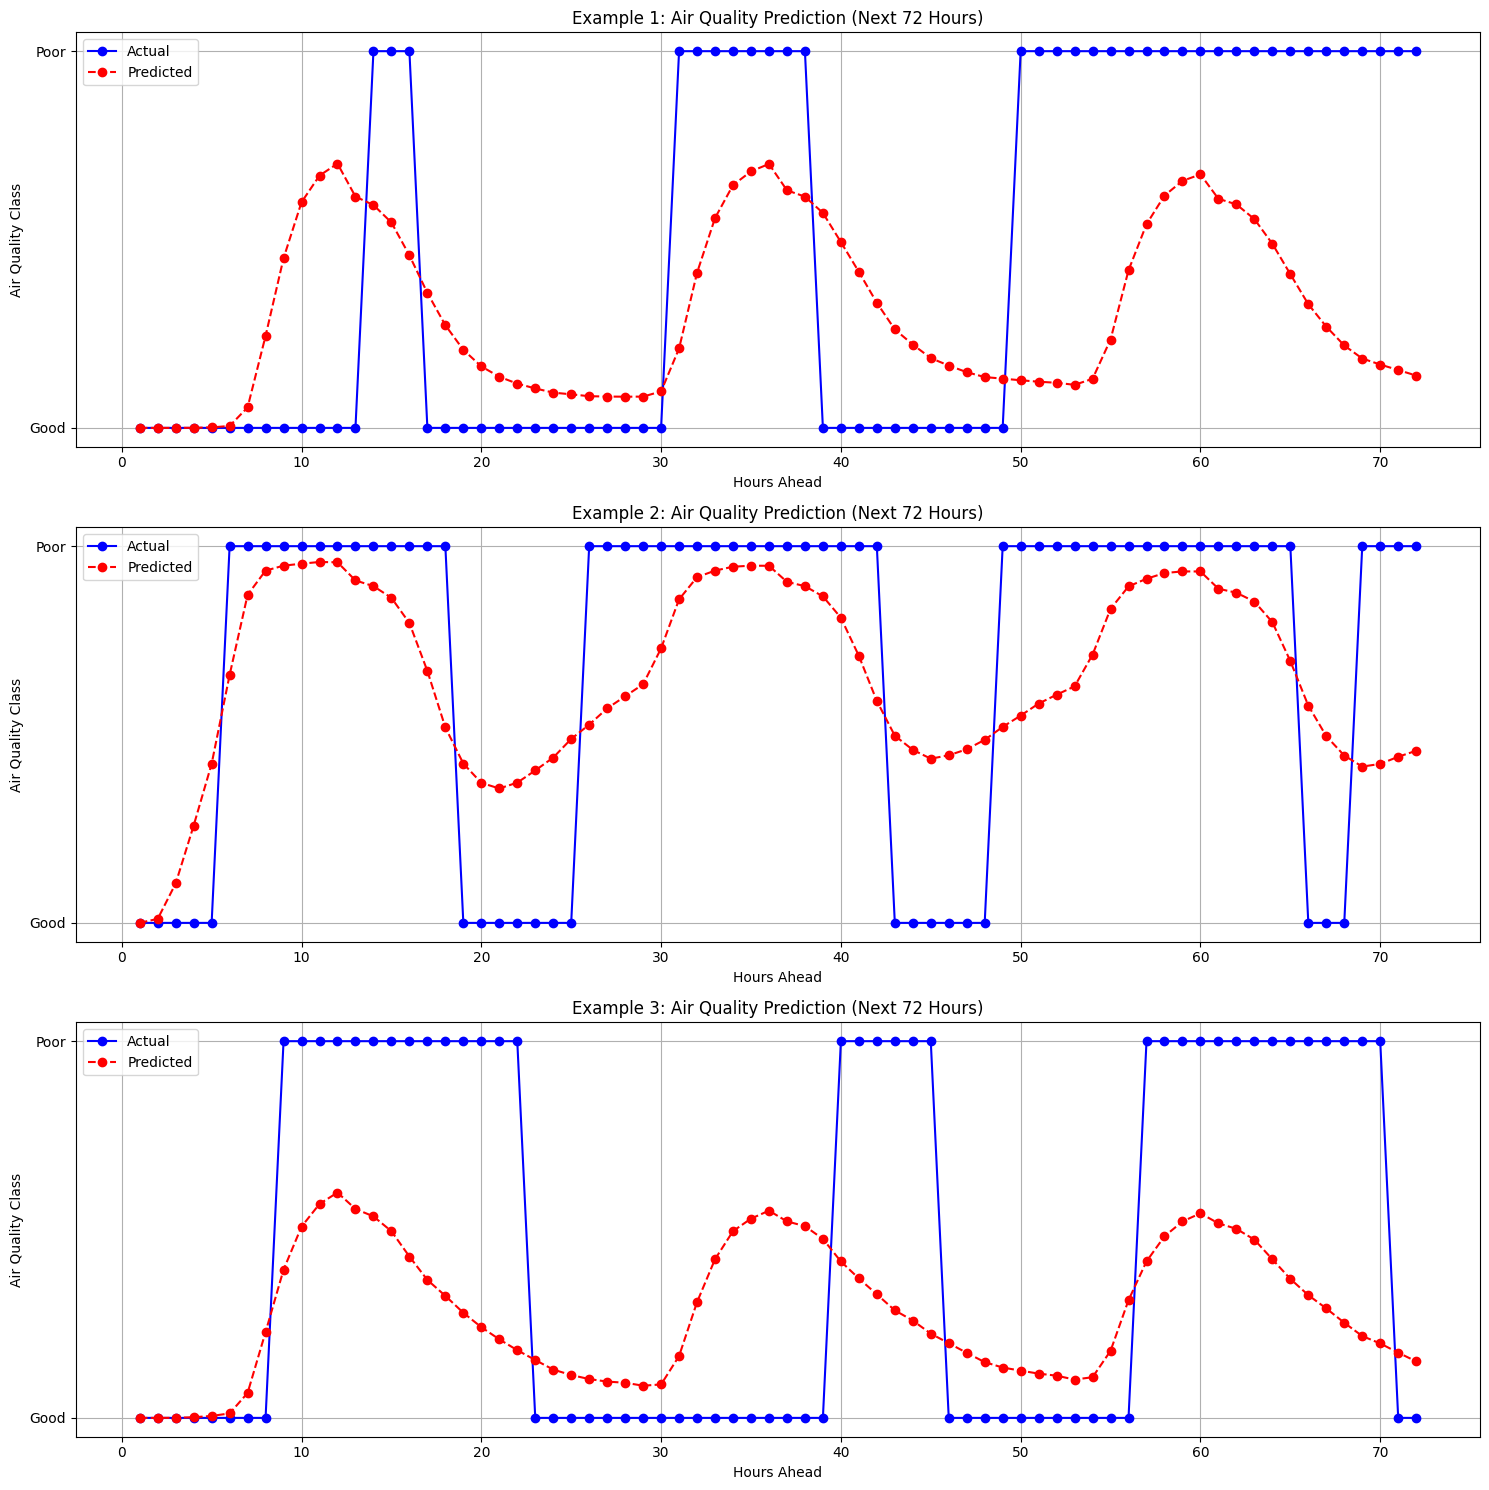

In [15]:
print("\nGenerating example predictions...")
X_test_plot = []
y_test_plot = []
for X_batch, y_batch in val_loader:
    X_test_plot.append(X_batch)
    y_test_plot.append(y_batch)
X_test_plot = torch.cat(X_test_plot, dim=0).numpy()
y_test_plot = torch.cat(y_test_plot, dim=0).numpy()

plot_example_predictions(model, X_test_plot, y_test_plot, num_examples=3)